In [51]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches
from matplotlib.patches import Patch
from datetime import datetime, timedelta
import numpy as np
import os
import math
import time
import sys
sys.path.append('..')

from source.utils import split_run_results, misc

# use colorblind color palette 
plt.style.use('tableau-colorblind10')


In [52]:
'''
    USER INPUT
'''

DO_SAVE = True

# resnet 101
#run_names = ['cifar100-resnet101-kernel-np4-pr0.5-lcm1e-04-batch16', 'cifar100-resnet101-kernel-np4-pr0.85-lcm1e-04-batch16']

# resnet 18
#run_names = ['resnet18_pr50_lcm0.0001_batch64', 'resnet18_pr75_lcm0.0001_batch64', 'resnet18_pr85_lcm0.0001_batch64'] # these logs dont have rx ip and port yet

# esc net 
#run_names = [f'esc-EscFusion-kernel-np4-pr{pr}-lcm1000' for pr in ["0.5", "0.7", "0.75", "0.8", "0.85"]]
#run_names = [f'esc-EscFusion-kernel-np4-pr0.5-lcm1000-run{i}' for i in range(1,4)]

# models to compare
log_names = ['resnet18', 'resnet101', 'EscFusion']
log_name = log_names[1]

# base log folder
base_log_folder = os.path.join('demo_logs')
run_names = [f.name for f in os.scandir(base_log_folder) if f.is_dir() and log_name in f.name] 

num_runs = len(run_names)
test_name = run_names[0]
num_nodes = 4 # TODO: update implementation to handle comparison of different number of machines 

save_dir = os.path.join('assets', 'figs', test_name)
log_file_path = os.path.join(base_log_folder, test_name)

if DO_SAVE:
    os.makedirs(save_dir, exist_ok=True)

In [53]:
block_event_df, layer_event_df, total_runtime = split_run_results.combine_log_files(log_file_path, log_name, num_nodes)

	 demo_logs\cifar100-resnet101-kernel-np4-pr0.5-lcm1e-05-run1\node0_resnet101.log
	 demo_logs\cifar100-resnet101-kernel-np4-pr0.5-lcm1e-05-run1\node1_resnet101.log
	 demo_logs\cifar100-resnet101-kernel-np4-pr0.5-lcm1e-05-run1\node2_resnet101.log
	 demo_logs\cifar100-resnet101-kernel-np4-pr0.5-lcm1e-05-run1\node3_resnet101.log


In [54]:
# TODO: this is not grabbing the correct timing for some reason. Total execution time is printed at the end of execution in log file of final node 
for i, rt in enumerate(total_runtime):
    print(f'{run_names[i]} {rt}')

cifar100-resnet101-kernel-np4-pr0.5-lcm1e-05-run1 3.3204613476991653
cifar100-resnet101-kernel-np4-pr0.5-lcm1e-05-run2 3.418808726593852
cifar100-resnet101-kernel-np4-pr0.5-lcm1e-05-run5 3.33670274913311
cifar100-resnet101-kernel-np4-pr0.75-lcm1e-05-run1 3.3216229369863868


In [55]:
''' 
    Make block event timeline plot
'''
#block_event_df[block_event_df['node'] == 0][['type', 'timestamp','time','dur', 'type']].head(7)
block_event_df


,timestamp,time,node,layer,layer_name,type,dur,process_dur,bytes_tx,serialize_dur,encode_dur_tx,ip,port,bytes_rx,deserialize_time,run
495,2024-10-15 00:50:56.970256177,0.000000,1,0,NaN,receive,1.743823,NaN,NaN,NaN,NaN,NaN,NaN,36.0,0.026391,1
0,2024-10-15 00:50:56.972000000,1.743823,1,0,NaN,idle,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
72,2024-10-15 00:50:56.972152958,1.896781,1,1,conv1,execute,2.847042,0.003438,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
353,2024-10-15 00:50:56.974334640,4.078463,1,1,NaN,total_send,13.665360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
424,2024-10-15 00:50:56.974871239,4.615062,1,1,NaN,prep,0.128762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,2024-10-15 00:51:00.310296489,3340.040312,1,244,NaN,receive,0.703511,NaN,NaN,NaN,NaN,NaN,NaN,9048.0,0.102885,1
422,2024-10-15 00:51:00.310308292,3340.052115,2,244,NaN,total_send,7.691708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
351,2024-10-15 00:51:00.312818578,3342.562401,2,244,NaN,send,4.181422,NaN,9048.0,0.125434,0.00132,172.30.203.209,49200.0,NaN,NaN,1
706,2024-10-15 00:51:00.314771965,3344.515788,1,244,NaN,receive,2.228035,NaN,NaN,NaN,NaN,NaN,NaN,9048.0,0.100888,1


## Plots Sandbox

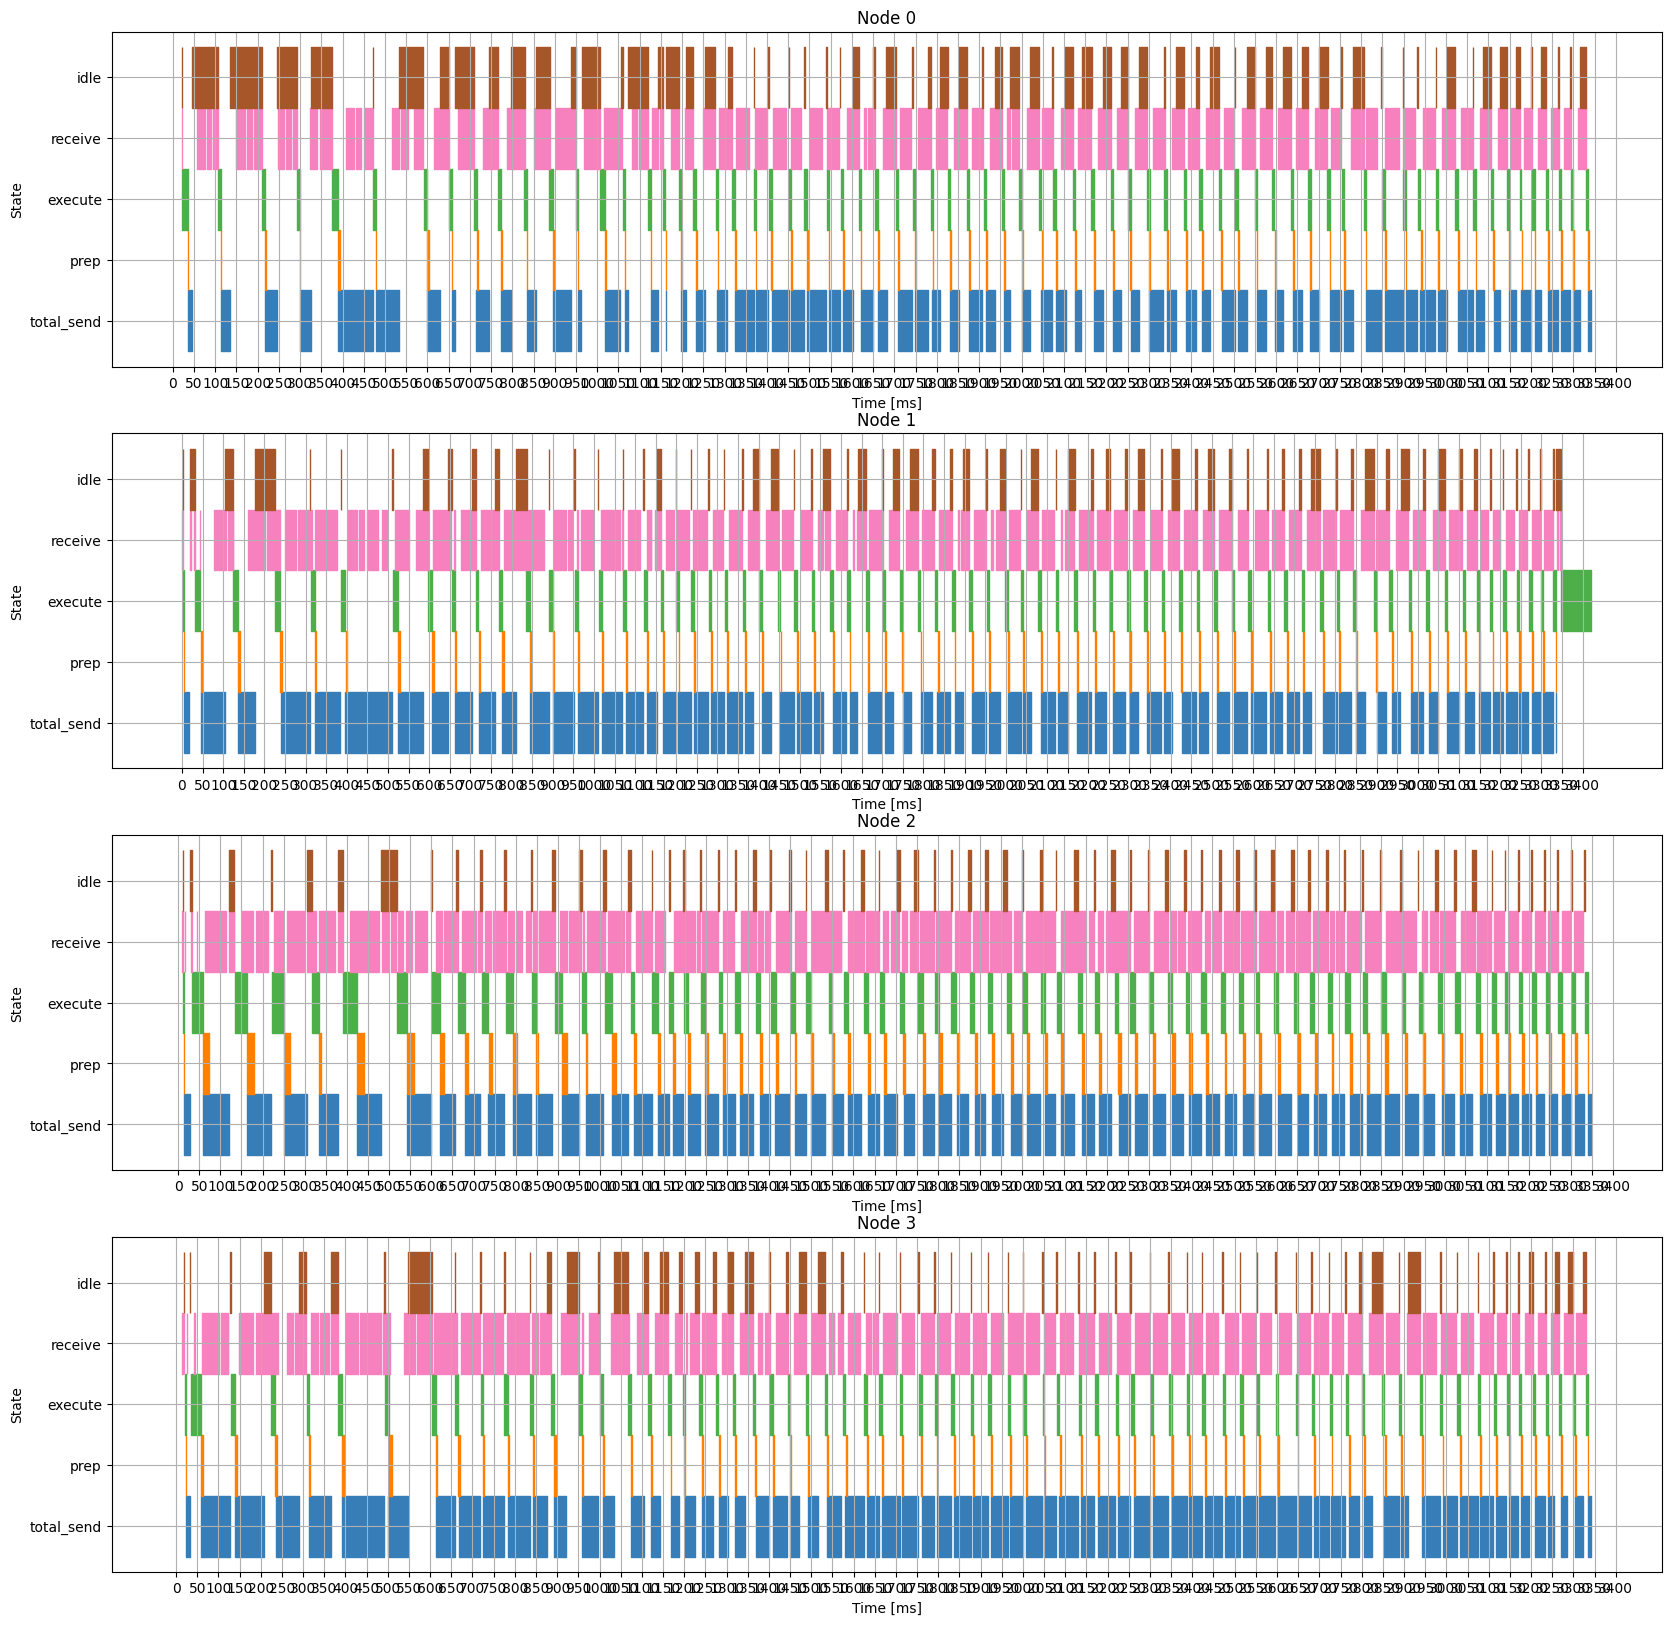

In [56]:
'''
    Plot timeline 
'''

def seq_of_tuples(df, col1, col2):
    return list(zip(df[col1], df[col2]))

# get layers that wait on inputs 
begin_block_layers = np.unique(block_event_df['layer'].to_numpy())

yheigth = 1
ystep = 1

comms_width = yheigth/num_nodes

fig, axs = plt.subplots(num_nodes, 1)
fig.set_size_inches(20,20)

# TODO: do for each node
inode = 0
state_types = ['total_send', 'prep','execute', 'receive', 'idle']
CB_color_cycle = ['#377eb8', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
num_states = len(state_types)

for inode in range(num_nodes):
    axs[inode].grid()
    for istate in range(num_states):

        state_type = state_types[istate]

        # format data and plot
        bars = seq_of_tuples(block_event_df.loc[(block_event_df['node'] == inode) & (block_event_df['type'] == state_type)], 'time', 'dur')
        axs[inode].broken_barh(bars, (ystep*istate - yheigth/2,yheigth), color=CB_color_cycle[istate])


    title_str = f'Node {inode}'
    axs[inode].set_title(title_str)
    axs[inode].set_xlabel('Time [ms]')
    axs[inode].set_ylabel('State')
    axs[inode].set_yticks(ticks=range(0, num_states*ystep, ystep), labels=state_types)

    xlim_range = []#[0, 200] #[700, 800]
    step_size = 50

    if [] == xlim_range:
        axs[inode].set_xticks(range(0, math.ceil(max(total_runtime)*1e3), step_size))
    else:
        axs[inode].set_xlim(xlim_range)
        axs[inode].set_xticks(range(xlim_range[0], xlim_range[1], step_size))
    
    #plt.legend(state_types)
    #plt.xlim(0,max(total_runtime)*1.1)

#fig.show()
#plt.ion()
#_ = plt.show()
    

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'block_execution_time.jpg'))




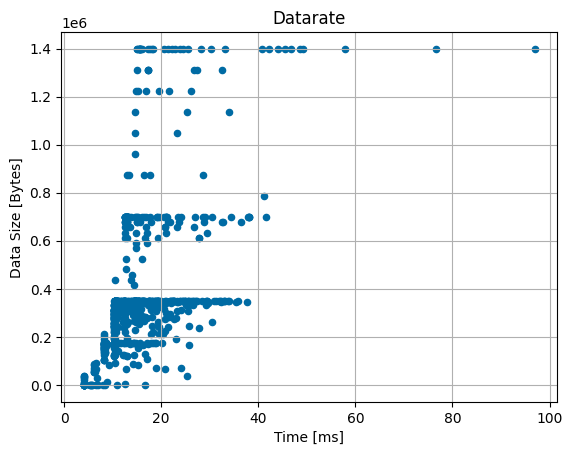

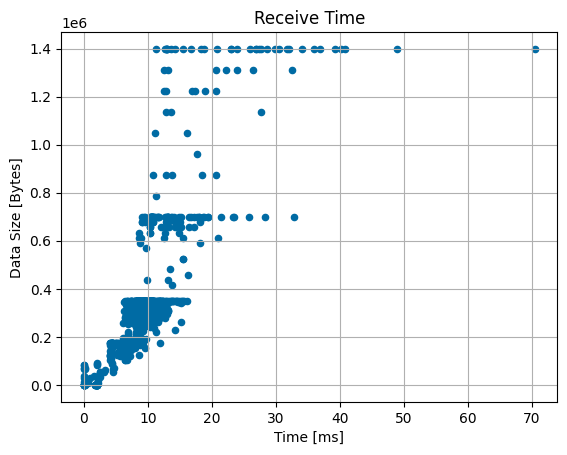

In [57]:
'''
    Make scatter plots for TX and RX
'''

ax_send = block_event_df[block_event_df['type'] == 'send'].plot.scatter(x='dur', y='bytes_tx')
ax_send.set_xlabel('Time [ms]')
ax_send.set_ylabel('Data Size [Bytes]')
ax_send.set_title('Datarate')
ax_send.grid()

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'datarate_send.jpg'))

# TODO: fix the measurment of time in debugger logging
ax_receive = block_event_df[block_event_df['type'] == 'receive'].plot.scatter(x='dur', y='bytes_rx')
ax_receive.set_xlabel('Time [ms]')
ax_receive.set_ylabel('Data Size [Bytes]')
ax_receive.set_title('Receive Time')
ax_receive.grid()

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'datarate_receive.jpg'))




In [58]:
'''
    Breakdown of total time spent in different states
'''

def sum_dur(df, type, node):
    mask = (df['type'] == type) & (df['node'] == node)
    return sum(df['dur'].loc[mask])

for i in range(num_nodes):
    total_idle_time = sum_dur(block_event_df, 'idle', i)
    total_process_time = sum_dur(block_event_df, 'process_dur', i)
    total_exec_time = sum_dur(block_event_df, 'execute', i)
    total_tx_time = sum_dur(block_event_df, 'send', i)
    total_prep_time = sum_dur(block_event_df, 'prep', i)
    total_rx_time = sum_dur(block_event_df, 'receive', i)
    timed_total_time = total_runtime[i]

    percent_idle = total_idle_time/total_runtime[i]*100/1e3
    percent_process_time = total_process_time/total_runtime[i]*100/1e3
    percent_exec_time = total_exec_time/total_runtime[i]*100/1e3
    percent_tx_time = total_tx_time/total_idle_time*100/1e3 # overlap in idle time and tx time
    percent_prep_time = total_prep_time/total_runtime[i]*100/1e3
    percent_rx_time = total_rx_time/total_idle_time*100
    percent_total_time =timed_total_time/total_runtime[i]*100/1e3

    data = {
            'States': ["IDLE", "CHECK IN (IDLE)", "TX (IDLE)", "RX (IDLE)", "EXECUTING", "PREP", "Total"], 
            'Time [ms]':[total_idle_time, total_process_time, total_tx_time, total_rx_time, total_exec_time, total_prep_time, timed_total_time],
            'Percent [%]':[percent_idle, percent_process_time, percent_tx_time, percent_rx_time, percent_exec_time, percent_prep_time, percent_total_time], 
            }
    df = pd.DataFrame(data)
    print(f'Node {i}')
    print(f'Run time {total_runtime[i]}s')
    print(df)
    print()


Node 0
Run time 3.3204613476991653s
            States    Time [ms]  Percent [%]
0             IDLE  1172.501149    35.311393
1  CHECK IN (IDLE)     0.000000     0.000000
2        TX (IDLE)  2718.347616     0.231842
3        RX (IDLE)  1885.331190   160.795680
4        EXECUTING   421.088275    12.681620
5             PREP   121.570956     3.661267
6            Total     3.320461     0.100000

Node 1
Run time 3.418808726593852s
            States    Time [ms]  Percent [%]
0             IDLE   589.152955    17.232697
1  CHECK IN (IDLE)     0.000000     0.000000
2        TX (IDLE)  3491.472079     0.592626
3        RX (IDLE)  2028.515340   344.310476
4        EXECUTING   554.334356    16.214255
5             PREP   169.585462     4.960367
6            Total     3.418809     0.100000

Node 2
Run time 3.33670274913311s
            States    Time [ms]  Percent [%]
0             IDLE   343.401222    10.291634
1  CHECK IN (IDLE)     0.000000     0.000000
2        TX (IDLE)  2816.415163     0.

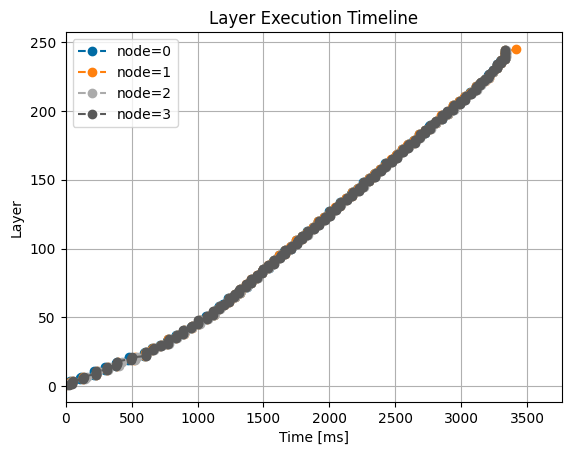

In [59]:
'''
    Look at layer execution times
'''

plt.figure()
plt.grid()
legend_strs = []
for i in range(4):
    plt.plot(layer_event_df[layer_event_df['node'] == i]['time'] ,layer_event_df[layer_event_df['node'] == i]['layer'], '--o')
    legend_strs += [f'node={i}']
plt.title('Layer Execution Timeline')
plt.xlabel('Time [ms]')
plt.ylabel('Layer')
plt.legend(legend_strs)
#_ = plt.xticks(np.arange(0, 10, step=1))
plt.xlim(0,max(total_runtime)*1.1*1e3)

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'layer_execution_time.jpg'))



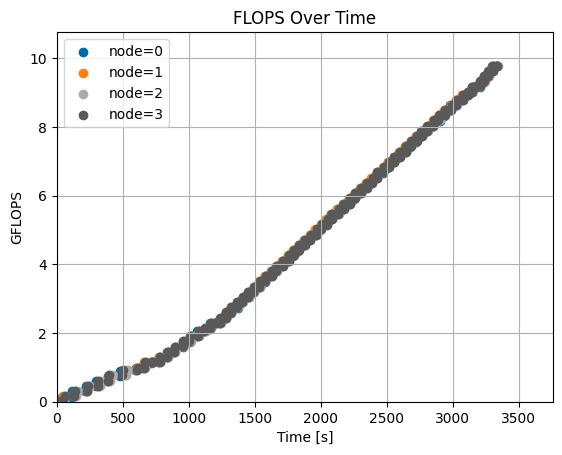

In [60]:

plt.figure()
plt.grid()
legend_strs = []
max_cum_bytes = 0
for i in range(num_nodes):

    tmp_merged_layer_df = layer_event_df[layer_event_df['node'] == i]
    nan_mask = tmp_merged_layer_df['FLOPS'].isna() == 0
    cum_bytes = np.cumsum(tmp_merged_layer_df[nan_mask]['FLOPS'].to_numpy())
    plt.scatter(tmp_merged_layer_df[nan_mask]['time'] ,cum_bytes/1e9)

    if max_cum_bytes < cum_bytes[-1]:
        max_cum_bytes = cum_bytes[-1]/1e9

    legend_strs += [f'node={i}']
plt.title('FLOPS Over Time')
plt.xlabel('Time [s]')
plt.ylabel('GFLOPS')
_ = plt.legend(legend_strs)
plt.xlim(0, max(layer_event_df['time'])*1.1)
plt.ylim(0,max_cum_bytes*1.1)
#_ = plt.xticks(np.arange(0, 250, step=20))

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'FLOPS.jpg'))


In [61]:
layer_event_df['FLOPS']

3      9437184.0
2      9437184.0
2      9437184.0
1       524288.0
240          NaN
         ...    
0            NaN
242          NaN
243          NaN
240     408000.0
0            NaN
Name: FLOPS, Length: 976, dtype: float64

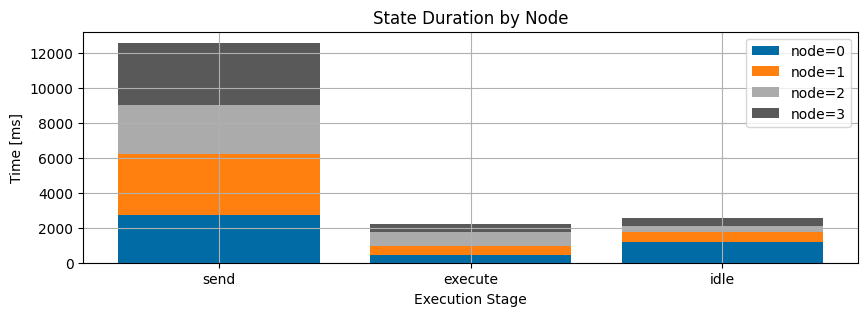

In [62]:
'''
    WIP Compare durations from different states 

'''

stages = ["send", "execute", "idle"]
num_stages = len(stages)
legend_strs = []

plt.figure(figsize=(10,3))
plt.grid()
bot = np.zeros(num_stages)
for inode in range(4):

    stages_array = np.array([])
    for a_stage in stages:
        stages_array = np.append(stages_array, block_event_df[(block_event_df['node'] == inode) & (block_event_df['type'] == a_stage) ]['dur'].sum(axis=0))
    plt.bar(stages, stages_array, bottom=bot)
    bot += stages_array

    legend_strs += [f'node={inode}']

plt.title(f'State Duration by Node')
plt.xlabel('Execution Stage')
plt.ylabel('Time [ms]')
plt.legend(legend_strs)

#_ = plt.xticks(layer_array*17.6, uniq_layers)
#plt.ylim(0, 50)

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, f'state_dur_compare_node-{test_name}.jpg'))

Processing run 0 = cifar100-resnet101-kernel-np4-pr0.5-lcm1e-05-run1 
	 demo_logs\cifar100-resnet101-kernel-np4-pr0.5-lcm1e-05-run1\node0_resnet101.log
	 demo_logs\cifar100-resnet101-kernel-np4-pr0.5-lcm1e-05-run1\node1_resnet101.log
	 demo_logs\cifar100-resnet101-kernel-np4-pr0.5-lcm1e-05-run1\node2_resnet101.log
	 demo_logs\cifar100-resnet101-kernel-np4-pr0.5-lcm1e-05-run1\node3_resnet101.log
Processing run 1 = cifar100-resnet101-kernel-np4-pr0.5-lcm1e-05-run2 
	 demo_logs\cifar100-resnet101-kernel-np4-pr0.5-lcm1e-05-run2\node0_resnet101.log
	 demo_logs\cifar100-resnet101-kernel-np4-pr0.5-lcm1e-05-run2\node1_resnet101.log
	 demo_logs\cifar100-resnet101-kernel-np4-pr0.5-lcm1e-05-run2\node2_resnet101.log
	 demo_logs\cifar100-resnet101-kernel-np4-pr0.5-lcm1e-05-run2\node3_resnet101.log
Processing run 2 = cifar100-resnet101-kernel-np4-pr0.5-lcm1e-05-run5 
	 demo_logs\cifar100-resnet101-kernel-np4-pr0.5-lcm1e-05-run5\node0_resnet101.log
	 demo_logs\cifar100-resnet101-kernel-np4-pr0.5-lcm1

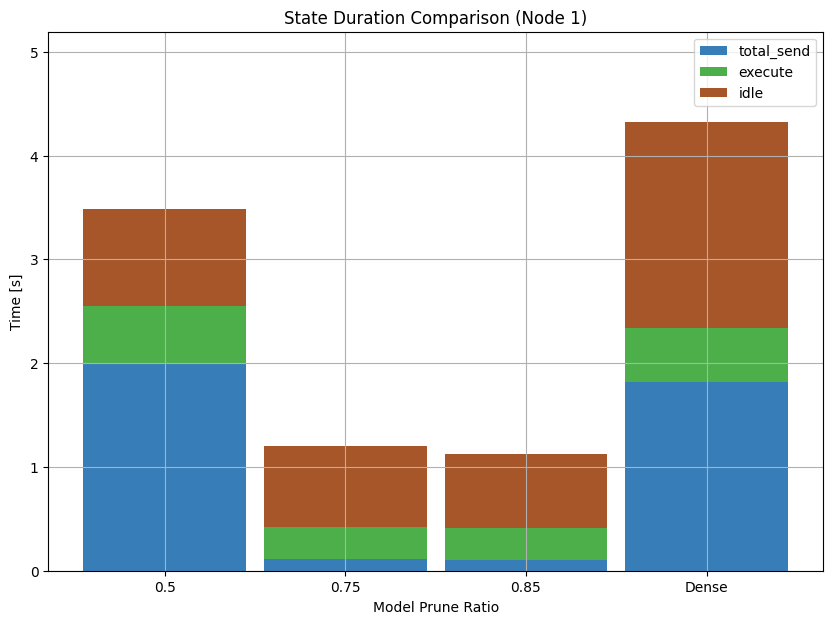

In [63]:
'''
    WIP Compare runtimes from different runs 

    # TODO: put bars next to one another 

'''

 
CB_color_cycle_short = ['#377eb8', '#4daf4a', '#a65628']
stages = ['total_send','execute', 'idle']
num_stages = len(stages)

# ticks 
legend_strs = []

width = 0.9

# make plot 
plt.figure(figsize=(10,7))
plt.grid()

# iterators
inode = 1
data_frames = []
model_names= []
bottom = np.zeros(num_runs)

# get df for each run 
for irun in range(num_runs):
    run_name = run_names[irun]
    print(f'Processing run {irun} = {run_name} ')
    run_name = run_names[irun]
    data_frames.append( split_run_results.combine_log_files(os.path.join(base_log_folder, run_name), log_name, num_nodes)[0] )

    # get params (assume runname is the same as model name)
    model_params = misc.parse_filename(run_name+'.pt')

    prune_ratio = model_params['pr']
    lcm = model_params['lcm']

    if prune_ratio == 0:
        model_names.append('Dense')
    else:
        model_names.append(f'{prune_ratio}')


# plot 1 stage at a time 
istage = 0
for a_stage in stages:

    # fill array with value for each run 
    stages_array = np.array([])
    for irun in range(num_runs):
        master_tmp = data_frames[irun] 
        stages_array = np.append(stages_array, master_tmp[(master_tmp['type'] == a_stage) & (master_tmp['node']==inode)]['dur'].sum(axis=0))

    # plot 
    plt.bar(model_names, stages_array/1e3, width=width, align='center', bottom=bottom/1e3, color=CB_color_cycle_short[istage])

    # increase counters
    bottom += stages_array
    istage += 1
    irun += 1

#ax = plt.gca()
#ax.set_yscale('log')

# labels
plt.title(f'State Duration Comparison (Node {inode})')
plt.xlabel('Model Prune Ratio')
plt.ylabel('Time [s]')
plt.legend(stages)

xlim_range = [0, max(bottom)*1.2/1e3]#[0, 200] #[700, 800]

if not [] == xlim_range:
    plt.ylim(xlim_range)

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'state_dur_compare_stacked.jpg'))

	 demo_logs\cifar100-resnet101-kernel-np4-pr0.5-lcm1e-05-run1\node0_resnet101.log
	 demo_logs\cifar100-resnet101-kernel-np4-pr0.5-lcm1e-05-run1\node1_resnet101.log
	 demo_logs\cifar100-resnet101-kernel-np4-pr0.5-lcm1e-05-run1\node2_resnet101.log
	 demo_logs\cifar100-resnet101-kernel-np4-pr0.5-lcm1e-05-run1\node3_resnet101.log
	 demo_logs\cifar100-resnet101-kernel-np4-pr0.5-lcm1e-05-run2\node0_resnet101.log
	 demo_logs\cifar100-resnet101-kernel-np4-pr0.5-lcm1e-05-run2\node1_resnet101.log
	 demo_logs\cifar100-resnet101-kernel-np4-pr0.5-lcm1e-05-run2\node2_resnet101.log
	 demo_logs\cifar100-resnet101-kernel-np4-pr0.5-lcm1e-05-run2\node3_resnet101.log
	 demo_logs\cifar100-resnet101-kernel-np4-pr0.5-lcm1e-05-run5\node0_resnet101.log
	 demo_logs\cifar100-resnet101-kernel-np4-pr0.5-lcm1e-05-run5\node1_resnet101.log
	 demo_logs\cifar100-resnet101-kernel-np4-pr0.5-lcm1e-05-run5\node2_resnet101.log
	 demo_logs\cifar100-resnet101-kernel-np4-pr0.5-lcm1e-05-run5\node3_resnet101.log
	 demo_logs\cifa

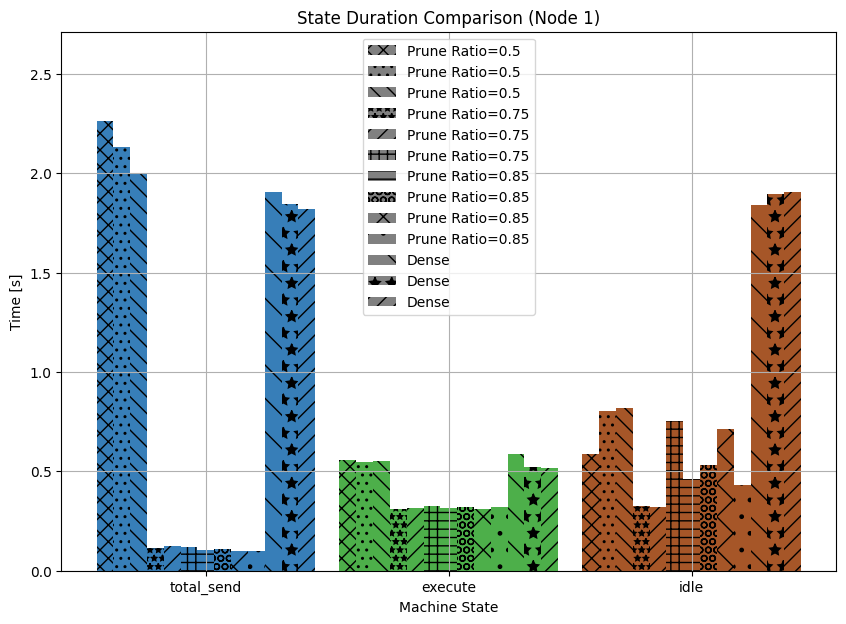

In [64]:
'''
    WIP Compare runtimes from different runs 

    # TODO: put bars next to one another 

'''
 
CB_color_cycle_short = ['#377eb8', '#4daf4a', '#a65628']
hatch_list = ["xx", "..", "\\\\", "**", '//', '++','--',"OO", "x", ".", "\\", "*", "//", "+", '-','O']
stages = ['total_send','execute', 'idle']
num_stages = len(stages)

# max ylim scale
max_ylim_scale = 1.2

# ticks 
width = 0.9
stage_values = np.arange(num_stages)*num_runs
run_values = np.arange(num_runs)*width
legend_strs = []

# make plot 
plt.figure(figsize=(10,7))
plt.grid()

# iterators
inode = 1
data_frames = []
model_names= []
bottom = np.zeros(num_runs)

# get df for each run 
for irun in range(num_runs):
    run_name = run_names[irun]
    data_frames.append( split_run_results.combine_log_files(os.path.join(base_log_folder, run_name), log_name, num_nodes)[0] )

    # get params (assume runname is the same as model name)
    model_params = misc.parse_filename(run_names[irun]+'.pt')

    prune_ratio = model_params['pr']
    lcm = model_params['lcm']

    if prune_ratio == 0:
        model_names.append('Dense')
    else:
        model_names.append(f'Prune Ratio={prune_ratio}')

    # make dummy bar for legend 
    plt.bar(0, 0, color="gray",  hatch= hatch_list[irun])

max_dur = 0

# plot 1 stage at a time 
istage = 0
for a_stage in stages:

    # fill array with value for each run 
    stages_array = np.array([])
    for irun in range(num_runs):
        master_tmp = data_frames[irun] 
        stage_time = master_tmp[(master_tmp['type'] == a_stage) & (master_tmp['node']==inode)]['dur'].sum(axis=0)

        # plot 
        plt.bar(stage_values[istage] + run_values[irun]  -width*num_runs/2 + width/2,
                    stage_time/1e3,
                    width=width,
                    align='center', 
                    color=CB_color_cycle_short[istage], 
                    hatch= hatch_list[irun])
        
        # update max 
        max_dur = max(max_dur, stage_time/1e3)

    # increase counters
    istage += 1
    irun += 1

# labels
plt.xticks(stage_values, stages)
plt.title(f'State Duration Comparison (Node {inode})')
plt.xlabel('Machine State')
plt.ylabel('Time [s]')
plt.legend(model_names)

#_ = plt.xticks(layer_array*17.6, uniq_layers)
plt.ylim(0, max_ylim_scale*max_dur)

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'state_dur_compare.jpg'))

In [65]:
'''
    Analyze log csvs after processing

'''

# load all resnet101 logs 
first_df = True
for run_name in run_names:
    log_path = os.path.join('demo_logs', run_name,'block_events.csv')
    block_df = pd.read_csv(log_path)
    
    # add extras 
    params = misc.parse_filename(run_name)
    block_df['run_name'] = run_name
    block_df['pr'] = params['pr']

    if first_df:
        all_block_df = block_df
        first_df = False
    else:
        all_block_df = pd.concat([all_block_df, block_df])



In [66]:
all_block_df.columns

Index(['timestamp', 'time', 'node', 'layer', 'layer_name', 'type', 'dur',
       'process_dur', 'bytes_tx', 'serialize_dur', 'encode_dur_tx', 'ip',
       'port', 'bytes_rx', 'deserialize_time', 'run', 'run_name', 'pr'],
      dtype='object')

In [67]:
print( pd.unique(all_block_df['run']) )
print( pd.unique(all_block_df['run_name']))

[1 2 5 3 4 'run1.1' 'run1.2' 'run1.3']
['cifar100-resnet101-kernel-np4-pr0.5-lcm1e-05-run1'
 'cifar100-resnet101-kernel-np4-pr0.5-lcm1e-05-run2'
 'cifar100-resnet101-kernel-np4-pr0.5-lcm1e-05-run5'
 'cifar100-resnet101-kernel-np4-pr0.75-lcm1e-05-run1'
 'cifar100-resnet101-kernel-np4-pr0.75-lcm1e-05-run2'
 'cifar100-resnet101-kernel-np4-pr0.75-lcm1e-05-run3'
 'cifar100-resnet101-kernel-np4-pr0.85-lcm1e-05-run1'
 'cifar100-resnet101-kernel-np4-pr0.85-lcm1e-05-run2'
 'cifar100-resnet101-kernel-np4-pr0.85-lcm1e-05-run3'
 'cifar100-resnet101-kernel-np4-pr0.85-lcm1e-05-run4'
 'cifar100-resnet101-run1.1' 'cifar100-resnet101-run1.2'
 'cifar100-resnet101-run1.3']


In [68]:
run_names

['cifar100-resnet101-kernel-np4-pr0.5-lcm1e-05-run1',
 'cifar100-resnet101-kernel-np4-pr0.5-lcm1e-05-run2',
 'cifar100-resnet101-kernel-np4-pr0.5-lcm1e-05-run5',
 'cifar100-resnet101-kernel-np4-pr0.75-lcm1e-05-run1',
 'cifar100-resnet101-kernel-np4-pr0.75-lcm1e-05-run2',
 'cifar100-resnet101-kernel-np4-pr0.75-lcm1e-05-run3',
 'cifar100-resnet101-kernel-np4-pr0.85-lcm1e-05-run1',
 'cifar100-resnet101-kernel-np4-pr0.85-lcm1e-05-run2',
 'cifar100-resnet101-kernel-np4-pr0.85-lcm1e-05-run3',
 'cifar100-resnet101-kernel-np4-pr0.85-lcm1e-05-run4',
 'cifar100-resnet101-run1.1',
 'cifar100-resnet101-run1.2',
 'cifar100-resnet101-run1.3']

In [103]:
send_time_dense = all_block_df[(all_block_df['run_name'] == 'cifar100-resnet101-run1.1') & (all_block_df['node'] == 1) & (all_block_df['type'] == 'total_send')]
send_time_50 = all_block_df[(all_block_df['run_name'] == 'cifar100-resnet101-kernel-np4-pr0.5-lcm1e-05-run1') & (all_block_df['node'] == 1) & (all_block_df['type'] == 'total_send')]

send_time_dense.set_index('layer', inplace=True)
send_time_50.set_index('layer', inplace=True)


In [106]:
'''
y_val = 'dur' #'serialize_dur'

f = plt.figure()
ax = plt.gca()

_ = send_time_dense.plot.scatter(x='layer', y=y_val, ax=ax, color='blue')
_ = send_time_50.plot.scatter(x='layer', y=y_val, ax=ax, color='red')

plt.grid()
_ = plt.legend(['0', '0.5'])
#plt.title()
#plt.xlim([0, 20])
'''

"\ny_val = 'dur' #'serialize_dur'\n\nf = plt.figure()\nax = plt.gca()\n\n_ = send_time_dense.plot.scatter(x='layer', y=y_val, ax=ax, color='blue')\n_ = send_time_50.plot.scatter(x='layer', y=y_val, ax=ax, color='red')\n\nplt.grid()\n_ = plt.legend(['0', '0.5'])\n#plt.title()\n#plt.xlim([0, 20])\n"

In [87]:
# confirm total send time is larger 
print(sum(send_time_dense['dur']))
print(sum(send_time_50['dur']))

1905.5059012025595
2260.5689307674766


<Axes: xlabel='layer'>

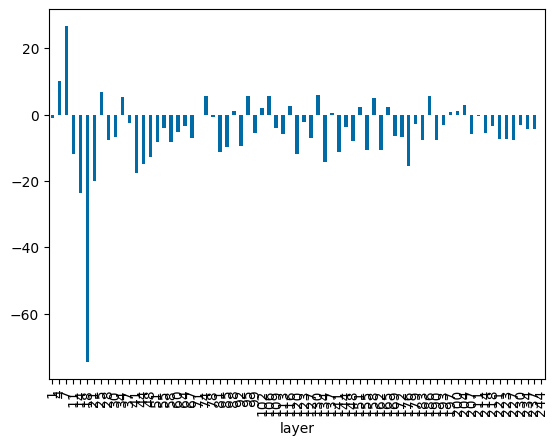

In [129]:
diff = send_time_dense['dur'].sub(send_time_50['dur'])
diff[diff.isna() == 0]

diff.plot.bar()

# negative means comm time is shorter for dense model  

In [130]:
# compare bytes sent
send_dense = all_block_df[(all_block_df['run_name'] == 'cifar100-resnet101-run1.1') & (all_block_df['node'] == 1) & (all_block_df['type'] == 'send')]
send_50 = all_block_df[(all_block_df['run_name'] == 'cifar100-resnet101-kernel-np4-pr0.5-lcm1e-05-run1') & (all_block_df['node'] == 1) & (all_block_df['type'] == 'send')]

send_dense.set_index('layer', inplace=True)
send_50.set_index('layer', inplace=True)

send_dense = send_dense.groupby(send_dense.index).sum()
send_50 = send_50.groupby(send_50.index).sum()

In [131]:
send_50.index

Index([  1,   4,   7,  11,  14,  18,  21,  25,  28,  30,  34,  37,  41,  44,
        48,  51,  55,  58,  60,  64,  67,  71,  74,  78,  81,  85,  88,  92,
        95,  99, 102, 106, 109, 113, 116, 120, 123, 127, 130, 134, 137, 141,
       144, 148, 151, 155, 158, 162, 165, 169, 172, 176, 179, 183, 186, 190,
       193, 197, 200, 204, 207, 211, 214, 218, 221, 223, 227, 230, 234, 237],
      dtype='int64', name='layer')

Text(0.5, 1.0, 'bytes_tx')

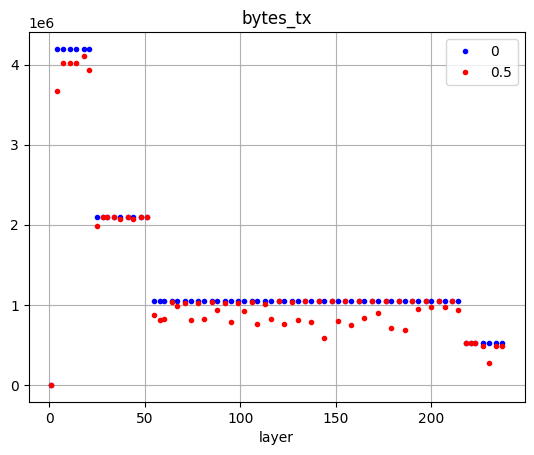

In [132]:
y_val='bytes_tx'

f = plt.figure()
ax = plt.gca()

_ = send_dense[y_val].plot(style='.', ax=ax, color='blue')
_ = send_50[y_val].plot(style='.', ax=ax, color='red')

plt.grid()
_ = plt.legend(['0', '0.5'])
#plt.title()
#plt.xlim([0, 20])

plt.title(y_val)
